In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda.representation.basis import BSpline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from IPython.core.display import display, HTML
from scipy.ndimage import gaussian_filter
from sklearn import decomposition
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

# Question 2
The ovarian cancer data set (“grp.csv” and “obs.csv” files) consists of gene data for 216 patients, 121 of whom have ovarian cancer, and 95 of whom do not. For each patient, there is a vector of data containing the expression of 4000 genes. The gene data is highly correlated, so that many patients have significant overlap in their gene expression. Please follow the below instructions to reduce the dimensionality of this problem:

a) Dimensionality reduction with Bspline and Lasso
* First, split the data set randomly (80% training set and 20% test set). 
* Use B-splines with 8 knots to reduce the dimensionality of the problem.
* Use lasso to learn the B-spline coefficients and report the values of coefficients. Note that Y values are “Cancer” or “Normal”, so the response type is binomial. Plot the coefficient values against lambdas.  
* Predict the probability of having cancer for the observations in the test dataset. Consider the threshold for the probability of having cancer and then compute the Mean Square Prediction Error. 

b) Dimensionality reduction with PCA and Lasso
* Now find the principal component of 4000 genes for both training and test set. Do not forget to scale data before PCA computation. Consider the 10 eigenvectors correspond to the 10 largest eigenvalues.
* Use lasso to learn the PCA coefficients and report the values of coefficients. Plot the coefficient values against lambdas.  
* Predict the probability of having cancer for the observations in the test dataset. Consider the same threshold for the probability similar to previous part and then compute the Mean Square Prediction Error. Compare the accuracy of part A and B.

#### Read in the data

In [2]:
datay = pd.read_csv('grp.csv', header=None)
dataX = pd.read_csv('obs.csv', header=None)

In [3]:
dataX.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.063915,0.033242,0.018484,0.008618,0.035629,0.037925,0.028865,0.061731,0.063100,0.024787,...,0.035119,0.021515,0.017385,0.018564,0.010027,0.012907,0.023405,0.038839,0.038151,0.032085
1,0.025409,0.051085,0.056305,0.021738,0.027410,0.014914,0.022455,0.023957,0.060527,0.047382,...,0.050841,0.055033,0.080864,0.053423,0.051942,0.013187,0.028573,0.020427,0.023261,0.019975


In [4]:
datay.head(2)

,0
0,Cancer
1,Cancer


In [5]:
def encode(case: str) -> int:
    if case == 'Cancer':
        return 1
    elif case == 'Normal':
        return 0
    else:
        raise Exception('invalid entry')

In [6]:
datay = datay.loc[:,0].apply(encode)

#### Split data set randomly 80% train, 20% test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataX.values, datay.values, test_size=0.2, random_state=42)

## Use B-splines with 8 knots to reduce dimenstionality

In [8]:
class fBSplines:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        #domain is linear space from 0 to 1 with as many points as columns in x
        self.domain = np.linspace(0,1,x.shape[1])
        
    def fit_splines(self, knots, degree):
        self.knots = knots
        #skfda BSpline object expects degree + 1 - if you want 3rd degree, must past 4
        self.degree = degree + 1
        
        self.bss = BSpline(knots=self.knots, order=self.degree)
        self.H = self.bss.evaluate(self.domain)
        
        
        #code borrowed from Johnathan Tay
        self.betas = np.linalg.lstsq(self.H.T, self.x.T, rcond=None)[0].T
        
            
        return self
            
     
   
    def train(self, clf, **kwargs):
        #train provided classifier on transformed xtrain
        self.clf = clf(penalty=kwargs['penalty'], solver=kwargs['solver'], random_state=kwargs['random_state'], max_iter=kwargs['max_iter'], Cs=kwargs['Cs'])
        self.clf.fit(self.betas, self.y)
        
    def predict(self, x=None, predict_train_data=False):
        #predict on training set
        if predict_train_data:
            preds = self.clf.predict(self.betas)
            return preds
        
        #predict on new data
        else:
            preds = self.clf.predict(x)
            return preds
        
        
        
    def transform(self,x):
        #transform new data with respect to created basis functions
        betas = np.linalg.lstsq(self.H.T, x.T, rcond=None)[0].T
        return betas

## Pepare data for prediction using b-spline basis functions with 8 knots

* Classifier will be Logistic Regression Classifier with L1 Regularization (LASSO)

In [9]:
# 8 knots
knots = np.linspace(0,1,8)
# 3rd order fit
degree = 3
# classifier
clf = LogisticRegressionCV
# range of C values to fit 0.0001 to 100
Cs = np.linspace(0.0001, 100, 100)

In [10]:
#instantiate and generate basis functions as well as find coefficients for basis functions
bs = fBSplines(x=X_train, y=y_train).fit_splines(knots=knots, degree=degree)

In [11]:
#train the lasso model on the train set
bs.train(clf=clf, penalty='l1', solver='liblinear', random_state=42, max_iter=100000, Cs=Cs)

In [12]:
#predict on the test set
prediction_probabilities = bs.clf.predict_proba(bs.transform(X_test))[:,1]

#### ROC / AUC

In [13]:
fpr, tpr, thresh = roc_curve(y_test, prediction_probabilities)

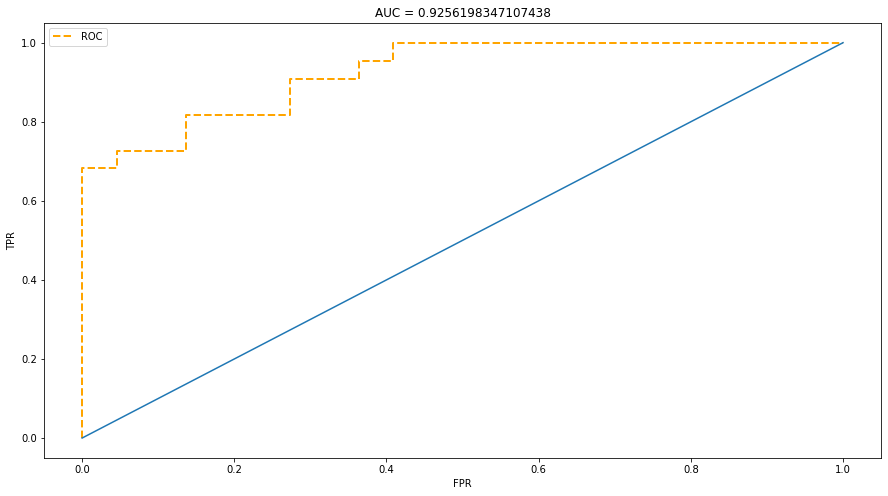

In [14]:
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='orange', ls='--', lw=2, label ='ROC')
plt.plot(fpr, fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC = {}'.format(roc_auc_score(y_test, prediction_probabilities)))
plt.legend()
plt.show()

In [15]:
def Find_Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [16]:
best_thresh = Find_Optimal_Cutoff(y_test, prediction_probabilities)[0]
print('Best threshold for prediction: {}'.format(best_thresh))

Best threshold for prediction: 0.7126312801202535


In [17]:
#function to apply thresholding
def threshold(data, thresh):
    data[data < thresh] = 0
    data[data >= thresh] = 1
    
    return data

In [18]:
preds = threshold(prediction_probabilities, best_thresh)
print('Test Set Accuracy: {}'.format(accuracy_score(y_test, preds)))

Test Set Accuracy: 0.8409090909090909


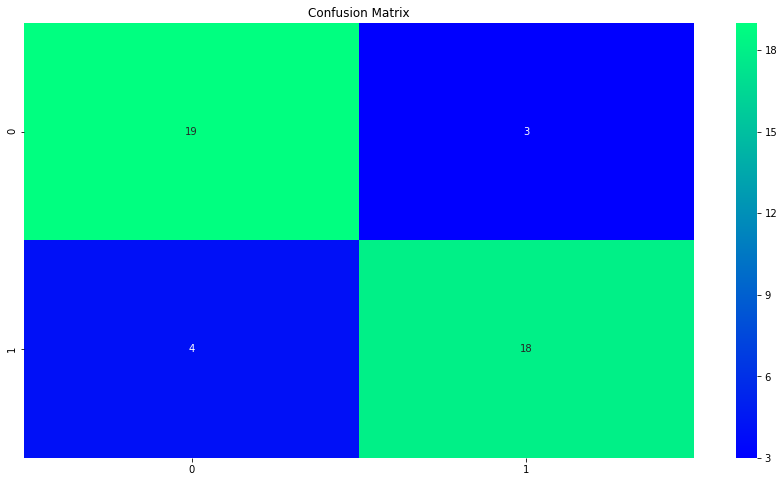

In [19]:
plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, cmap='winter')
plt.title('Confusion Matrix')
plt.show()

#### Plot Coefficients with values of C where C = (1/lambda)

In [20]:
def plot_coefs(coefs):
    fig = plt.subplots(nrows=2,ncols=3, figsize=(15,10))
    for i in range(coefs.shape[0]):
        plt.subplot(2,3,i+1)
        plt.plot(coefs[i])
        plt.title('Coef Path - CV Fold {}'.format(i+1))
        plt.xlabel('Value of C (1/lambda)')
        plt.ylabel('Coefficient Value')

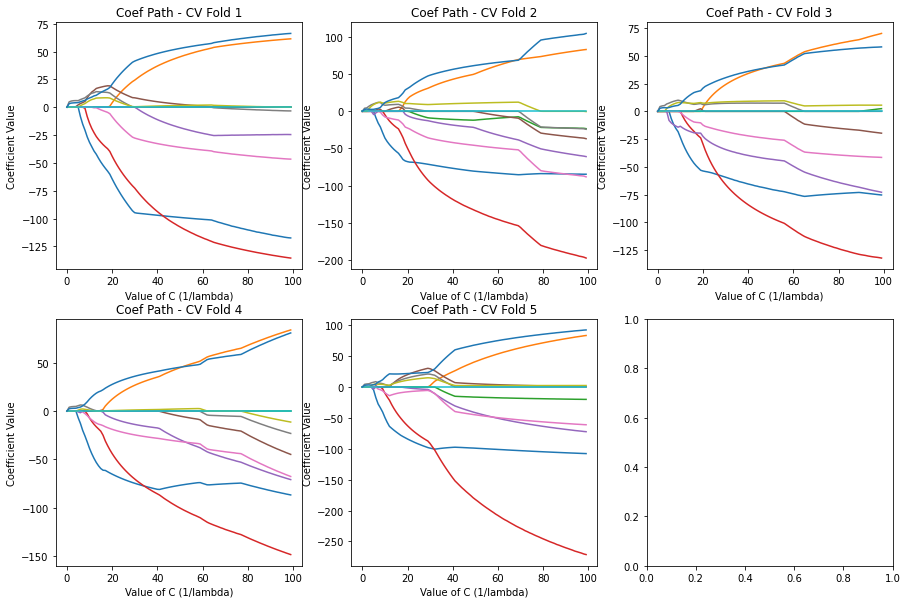

In [21]:
plot_coefs(bs.clf.coefs_paths_[1])

## Using PCA with 10 Components to Reduce Dimensionality

In [22]:
class FPCA:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        #domain is linear space from 0 to 1 with as many points as columns in x
        self.domain = np.linspace(0,1,x.shape[1])
        
    def fit_splines(self, knots, degree, show_fit=False):
        #knots attribute
        self.knots = knots
        
        #skfda BSpline object expects degree + 1 - if you want 3rd degree, must past 4
        self.degree = degree + 1
        
        #fit bspline object
        self.bss = BSpline(knots=self.knots, order=self.degree)
        
        #evaluate basis functions across domain
        self.H = self.bss.evaluate(self.domain)
        
        #code borrowed from Johnathan Tay
        self.H_stacked = np.tile(self.H, self.x.shape[0]).T
        
        #code borrowed from Johnathan Tay
        self.X_stacked = self.x.ravel().reshape(-1,1)
        
        #code borrowed from Johnathan Tay
        
        self.beta = np.linalg.lstsq(self.H_stacked, self.X_stacked, rcond=None)[0]
        
        #code borrowed from Johnathan Tay
        self.mu_hat = self.H.T.dot(self.beta)
        
        if show_fit:
            plt.figure(figsize=(15,8))
            for x in Xtrain:
                plt.plot(x)

            plt.plot(self.mu_hat, lw='6', label='mu',path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])
            plt.legend()
            plt.show()
            
        return self
            
     
        
    def PCA(self, n_components=None):
        #center the data from the line of best fit of all curves (mean curve)
        #code borrowed from Johnathan Tay
        self.diffs = self.x - self.mu_hat.T
        
        #Smooth out covariance matrix
        #code borrowed from Johnathan Tay
        self.Cov = gaussian_filter(np.cov(self.diffs.T), sigma=7)
        
        #used to visualize explained variance for determination of the proper number of components needed
        if n_components == None:
            self.pca = decomposition.PCA()

            self.pca.fit(self.Cov)

            var = self.pca.explained_variance_
            fig = plt.figure(figsize=(15,8))
            plt.plot(range(len(var)), var, marker='o')
            plt.xlabel('Number of Components')
            plt.ylabel('Explained Variance')
            plt.title('PCA ELbow Chart')
            plt.show()
        else:
            #fit and return desired number of principal components
            self.pca = decomposition.PCA(n_components=n_components)
            self.pca.fit(self.Cov)
            
            self.FPC_scores = self.pca.transform(self.diffs)
            
    def train(self, clf, **kwargs):
        #train provided classifier on transformed xtrain data
        self.clf = clf(penalty=kwargs['penalty'], solver=kwargs['solver'], random_state=kwargs['random_state'], max_iter=kwargs['max_iter'], Cs=kwargs['Cs'])
        self.clf.fit(self.FPC_scores, self.y)
        
    def predict(self, x=None, predict_train_data=False):
        #return predictins on train data
        if predict_train_data:
            preds = self.clf.predict(self.FPC_scores)
            return preds
        
        #return predictions on new data
        else:
            preds = self.clf.predict(x)
            return preds
        
        
        
    def transform(self,x):
        #transform new data to proper orientation
        diffs = x - self.mu_hat.T
        FPC_scores = self.pca.transform(diffs)
        
        return FPC_scores

#### Scale the Data

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### fit the data with splines then extract the principle components

In [24]:
fpca = FPCA(x=X_train_scaled, y=y_train).fit_splines(knots=knots, degree=degree, show_fit=False)

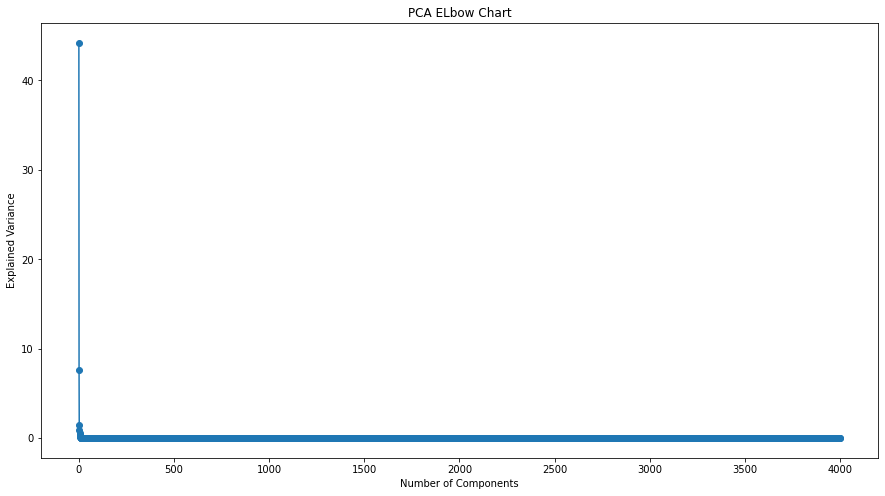

In [25]:
#view the elbow chart
fpca.PCA()

#### See how much variance is explained by the first 10 components 

In [26]:
tot = 0
for pos, var in enumerate(fpca.pca.explained_variance_ratio_[:10]):
    tot += var
    print('Variance explained by first {} components: {}'.format(pos+1, str(round(tot,5)*100) + '%'))

Variance explained by first 1 components: 79.357%
Variance explained by first 2 components: 92.928%
Variance explained by first 3 components: 95.526%
Variance explained by first 4 components: 97.038%
Variance explained by first 5 components: 97.969%
Variance explained by first 6 components: 98.586%
Variance explained by first 7 components: 99.095%
Variance explained by first 8 components: 99.33999999999999%
Variance explained by first 9 components: 99.496%
Variance explained by first 10 components: 99.56700000000001%


In [27]:
#extract first 10 components
fpca.PCA(n_components=10)

In [28]:
#Train the lasso model on the PCA coefficients
fpca.train(clf=clf, penalty='l1', solver='liblinear', random_state=42, max_iter=1000, Cs=Cs)

In [29]:
#transform X_test_scaled with respect to the 10 PCs  
X_test_fpca = fpca.transform(X_test_scaled)

In [30]:
#predict on the test set
prediction_probabilities = fpca.clf.predict_proba(fpca.transform(X_test_scaled))[:,1]

In [31]:
#extract false positive rate and true positive rate for ROC
fpr, tpr, thresh = roc_curve(y_test, prediction_probabilities)

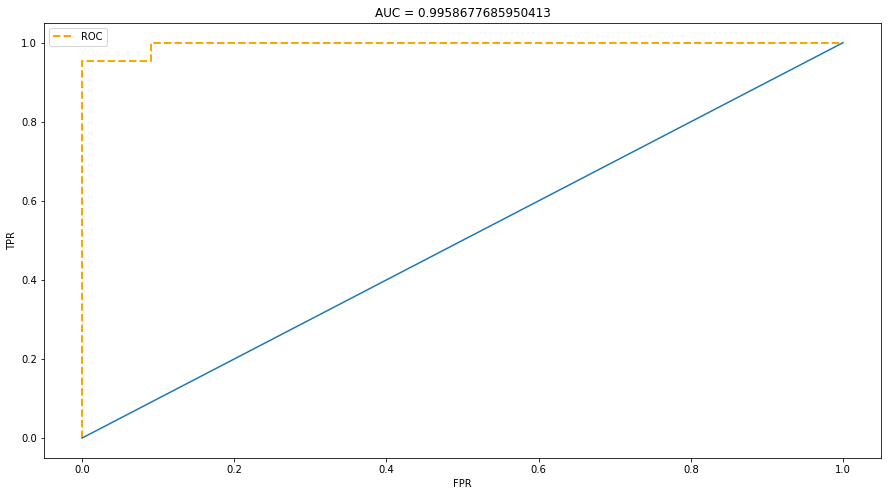

In [32]:
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='orange', ls='--', lw=2, label ='ROC')
plt.plot(fpr, fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC = {}'.format(roc_auc_score(y_test, prediction_probabilities)))
plt.legend()
plt.show()

In [33]:
preds = threshold(prediction_probabilities, best_thresh)
accuracy_score(y_test, preds)

0.9545454545454546

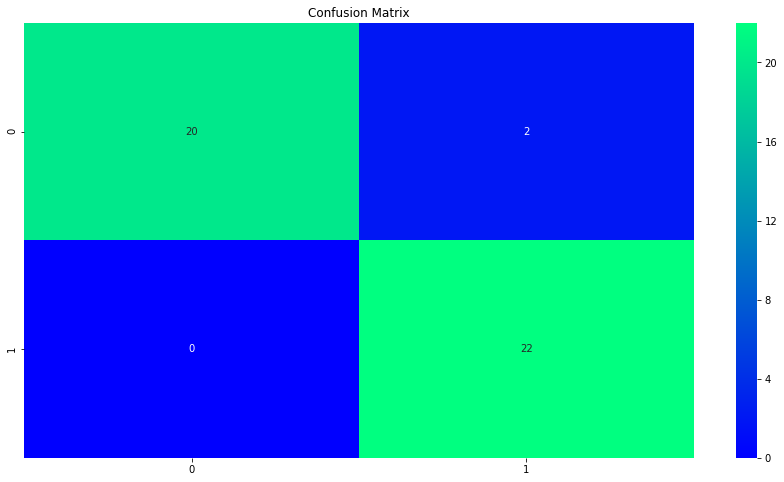

In [34]:
plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, cmap='winter')
plt.title('Confusion Matrix')
plt.show()

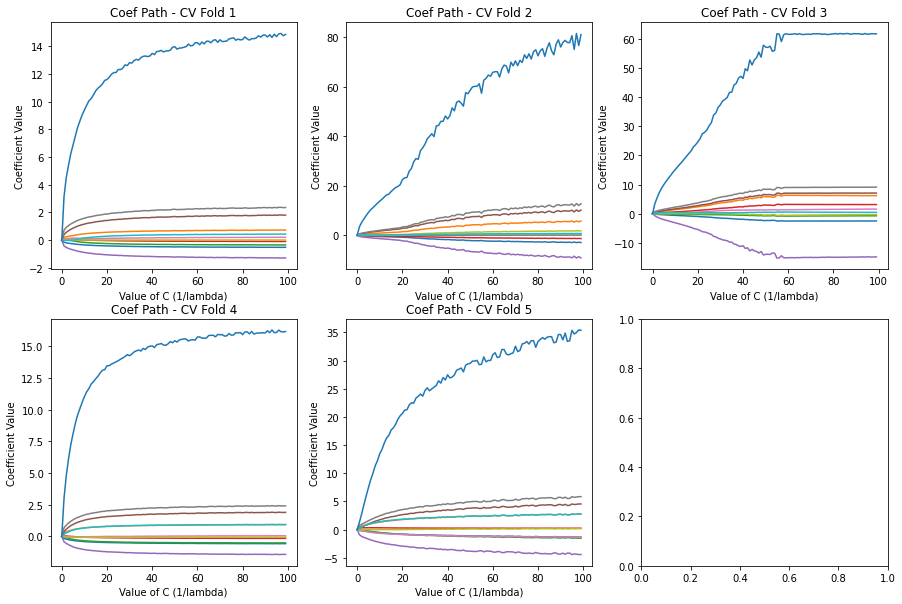

In [35]:
plot_coefs(fpca.clf.coefs_paths_[1])

## Results

PCA achieved higher accuracy on the test set over simple B-spline reduction. At an accuracy rate of 84%, B-splines misclassified 7 observations. Conversely with an accuracy score of ~96%, PCA only failed to properly classify 2 observations in the test set after applying logistical regression cross validation. 